In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

In [ ]:
uploaded = files.upload()

Saving arman.zip to arman.zip


In [ ]:
!unzip './arman.zip'

Archive:  ./arman.zip
   creating: arman/
  inflating: arman/dev.txt           
  inflating: arman/test.txt          
  inflating: arman/train.txt         


In [ ]:
def read_conll(file_path):
    sentences, labels = [], []
    sent, lab = [], []
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            if line.strip()=="":
                if sent:
                    sentences.append(sent)
                    labels.append(lab)
                    sent, lab =[], []

            else:
                token, tag = line.strip().split()
                sent.append(token)
                lab.append(tag)

    return sentences, labels

In [ ]:
sentences, tags = read_conll('./arman/train.txt')
test_sentences, test_tags = read_conll('./arman/test.txt')

print(sentences[0])
print(test_sentences[0])

['به', 'عنوان', 'مثال', 'وقتی', 'نشریات', 'مدافع', 'اصول', 'و', 'ارزشها', 'و', 'منادی', 'انقلاب', 'و', 'اسلام', 'در', 'بالاترین', 'درجه', '،', 'اولین', 'و', 'درشت\u200cترین', 'تیتر', 'نشریه', 'خود', 'را', 'در', 'صدر', 'صفحه', 'نخستین', '،', 'به', 'تکذیب', 'اظهارات', 'و', 'نظریات', 'مشاور', 'رئیس\u200cجمهور', 'با', 'همین', 'ترکیب', 'عبارتی', 'و', 'البته', 'از', 'قول', 'دیگران', 'اختصاص', 'می\u200cدهند', '،', 'آیا', 'در', 'موارد', 'مشابه', 'نیز', 'هر', 'گاه', 'خبر', 'تکذیب', 'متوجه', 'و', 'معطوف', 'به', 'شخصی', 'باشد', 'كه', 'در', 'زمره', 'مشاوران', 'يك', 'مقام', 'بلندمرتبه\u200cی', 'دیگر', 'است', '،', 'خبر', 'را', 'عینا', 'به', 'همین', 'درشتی', 'و', 'با', 'همین', 'ترکیب', 'عبارتی', 'در', 'صدر', 'صفحه', 'نخست', 'به', 'چاپ', 'می\u200cرساند', 'و', 'در', 'آن', 'مورد', 'هم', 'به', 'جای', 'ذکر', 'نام', 'يا', 'عضویت', 'آن', 'شخص', 'در', 'گروه', 'و', 'کمیته\u200cی', 'خاص', 'صرفا', 'بر', 'روی', 'عنوان', 'مشاور', 'فلان', 'مسئول', 'بلندمرتبه', 'تأکید', 'می\u200cکنند', '؟', 'اگر', 'نشریه', 'دیگری',

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_sentences, valid_sentences, train_tags, valid_tags = train_test_split(sentences, tags, test_size=0.15, random_state=42)

In [ ]:
print(train_sentences[0])

['وزیر', 'اطلاعات', 'از', 'قدرتهای', 'نظامی', '،', 'اقتصادی', '،', 'علمی', '،', 'دیپلماسی', 'و', 'فرهنگ', 'ملی', 'به', 'عنوان', 'مؤلفه\u200cهای', 'امنیت', 'ملی', 'کشور', 'یاد', 'کرد', 'و', 'گفت', ':', 'همه', 'آنها', 'باید', 'در', 'اوج', 'اقتدار', 'و', 'هماهنگ', 'عمل', 'کنند', 'تا', 'کشور', 'به', 'يك', 'امنیت', 'پایدار', 'و', 'توسعه', 'كه', 'هدف', 'دولت', 'خدمتگزار', 'است', '،', 'دست', 'یابد', '.']


In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

unique_tags = sorted(set(tag for doc in train_tags for tag in doc))
tag2id = {tag: i for i, tag in enumerate(unique_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
def encode_tags(tags, encodings):
    labels = []
    for i, doc_labels in enumerate(tags):
        word_ids = encodings.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(tag2id[doc_labels[word_idx]])
            else:
                label_ids.append(tag2id[doc_labels[word_idx]])
            previous_word_idx = word_idx
        labels.append(label_ids)
    return labels

In [ ]:
print(f"len train sentences: {len(train_sentences)} and len train tags: {len(train_tags)}")

len train sentences: 8704 and len train tags: 8704


In [ ]:
for i, (tokens, tags) in enumerate(zip(train_sentences, train_tags)):
    if len(tokens) != len(tags):
        print(f"Sentence {i} has {len(tokens)} tokens but {len(tags)} tags")

Sentence 0 has 52 tokens but 0 tags


In [ ]:
def clean_misaligned(sentences, tags):
    clean_sentences, clean_tags = [], []
    for i, (s, t) in enumerate(zip(sentences, tags)):
        if len(s) == len(t) and len(t) > 0:
            clean_sentences.append(s)
            clean_tags.append(t)
        else:
            print(f"Skipping sentence {i} -> {len(s)} tokens, {len(t)} tags")
    return clean_sentences, clean_tags

In [ ]:
train_sentences, train_tags = clean_misaligned(train_sentences, train_tags)
valid_sentences, valid_tags = clean_misaligned(valid_sentences, valid_tags)
test_sentences, test_tags   = clean_misaligned(test_sentences, test_tags)

Skipping sentence 0 -> 52 tokens, 0 tags


In [ ]:
train_encodings = tokenizer(train_sentences, is_split_into_words=True, truncation=True, padding=True, return_offsets_mapping=True)
valid_encodings = tokenizer(valid_sentences, is_split_into_words=True, truncation=True, padding=True, return_offsets_mapping=True)
test_encodings = tokenizer(test_sentences, is_split_into_words=True, truncation=True, padding=True, return_offsets_mapping=True)

train_labels_enc = encode_tags(train_tags, train_encodings)
valid_labels_enc = encode_tags(valid_tags, valid_encodings)
test_labels_enc = encode_tags(test_tags, test_encodings)

train_encodings.pop("offset_mapping")
valid_encodings.pop("offset_mapping")
test_encodings.pop("offset_mapping")

[[(0, 0),
  (0, 4),
  (0, 1),
  (0, 1),
  (0, 1),
  (0, 2),
  (0, 5),
  (0, 5),
  (0, 5),
  (0, 1),
  (0, 9),
  (0, 5),
  (0, 2),
  (0, 6),
  (0, 7),
  (0, 3),
  (0, 3),
  (0, 7),
  (0, 2),
  (0, 3),
  (0, 3),
  (0, 11),
  (0, 2),
  (0, 4),
  (0, 3),
  (0, 2),
  (0, 5),
  (0, 5),
  (0, 2),
  (0, 1),
  (0, 1),
  (0, 7),
  (0, 2),
  (0, 5),
  (6, 11),
  (0, 1),
  (0, 5),
  (0, 1),
  (0, 4),
  (0, 1),
  (0, 6),
  (0, 1),
  (0, 3),
  (0, 1),
  (0, 1),
  (0, 2),
  (0, 3),
  (0, 5),
  (0, 1),
  (0, 7),
  (0, 1),
  (0, 6),
  (0, 6),
  (0, 6),
  (0, 2),
  (0, 4),
  (0, 6),
  (0, 1),
  (0, 1),
  (0, 3),
  (0, 6),
  (0, 5),
  (0, 1),
  (0, 6),
  (0, 1),
  (0, 4),
  (0, 3),
  (0, 1),
  (0, 1),
  (0, 3),
  (0, 3),
  (0, 4),
  (0, 1),
  (0, 2),
  (0, 5),
  (0, 2),
  (0, 10),
  (0, 4),
  (0, 5),
  (0, 6),
  (0, 1),
  (0, 2),
  (0, 6),
  (0, 6),
  (0, 9),
  (0, 2),
  (0, 2),
  (0, 3),
  (0, 13),
  (0, 4),
  (0, 2),
  (0, 6),
  (0, 3),
  (0, 1),
  (0, 7),
  (0, 6),
  (0, 1),
  (0, 1),
  (0, 4),
  (0, 

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=198f1f6dcb3ba57541f35ec5f6df9a89f191240871034842e14b5e78cd32005b
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [ ]:
import torch
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from seqeval.metrics import classification_report

In [ ]:
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
train_dataset = NERDataset(train_encodings, train_labels_enc)
valid_dataset = NERDataset(valid_encodings, valid_labels_enc)
test_dataset = NERDataset(test_encodings, test_labels_enc)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(unique_tags), id2label=id2tag, label2id=tag2id)

args = TrainingArguments(
    output_dir="./parsbert-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_preds, true_labels = [], []
    for pred, lab in zip(predictions, labels):
        for p_i, l_i in zip(pred, lab):
            if l_i != -100:
                true_preds.append(id2tag[p_i])
                true_labels.append(id2tag[l_i])
    return {"report": classification_report([true_labels], [true_preds])}

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-2343330697.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=2720, training_loss=0.0379577486173195, metrics={'train_runtime': 2484.3485, 'train_samples_per_second': 17.516, 'train_steps_per_second': 1.095, 'total_flos': 5596890051495960.0, 'train_loss': 0.0379577486173195, 'epoch': 5.0})

In [ ]:
metrics = trainer.evaluate()
print(metrics["eval_report"])

              precision    recall  f1-score   support

       event       0.93      0.95      0.94       588
         fac       0.96      0.97      0.96       567
         loc       0.98      0.98      0.98      3526
         org       0.97      0.98      0.97      4741
        pers       0.99      0.99      0.99      3657
         pro       0.97      0.97      0.97       802

   micro avg       0.97      0.98      0.98     13881
   macro avg       0.97      0.97      0.97     13881
weighted avg       0.97      0.98      0.98     13881



In [ ]:
!pip install arabic_reshaper
!pip install python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 7.2 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from seqeval.metrics import classification_report
import arabic_reshaper
from bidi.algorithm import get_display

def flatten_preds_labels(pred_output, id2tag):
    preds = np.argmax(pred_output.predictions, axis=2)
    labels = pred_output.label_ids
    flat_true, flat_pred = [], []
    for p_seq, l_seq in zip(preds, labels):
        for p, l in zip(p_seq, l_seq):
            if l != -100:  # فقط توکن‌های واقعی
                flat_true.append(id2tag[l])
                flat_pred.append(id2tag[p])
    return flat_true, flat_pred

=== Test (entity-level) classification report ===
              precision    recall  f1-score   support

       event       0.94      0.96      0.95       588
         fac       0.95      0.97      0.96       567
         loc       0.98      0.98      0.98      3526
         org       0.97      0.98      0.97      4741
        pers       0.99      0.99      0.99      3657
         pro       0.96      0.96      0.96       802

   micro avg       0.97      0.98      0.98     13881
   macro avg       0.96      0.97      0.97     13881
weighted avg       0.97      0.98      0.98     13881



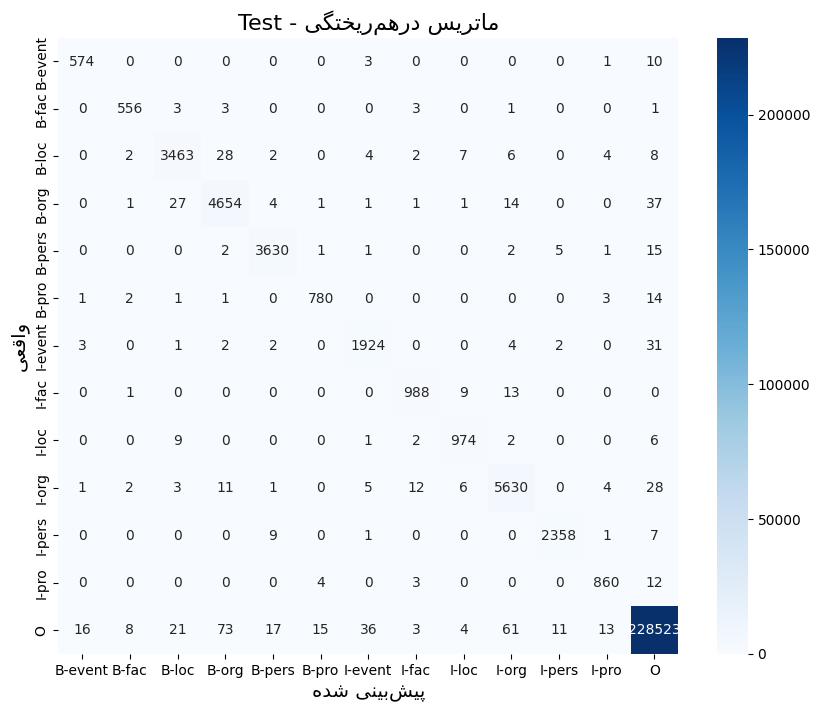

In [ ]:
preds_test = trainer.predict(test_dataset)
y_true_test, y_pred_test = flatten_preds_labels(preds_test, id2tag)

print("=== Test (entity-level) classification report ===")
print(classification_report([y_true_test], [y_pred_test]))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=unique_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_fixed, yticklabels=labels_fixed)
plt.xlabel(get_display(arabic_reshaper.reshape("پیش‌بینی شده")), fontsize=14)
plt.ylabel(get_display(arabic_reshaper.reshape("واقعی")), fontsize=14)
plt.title(get_display(arabic_reshaper.reshape("ماتریس درهم‌ریختگی - Test")), fontsize=16)
plt.show()